In [40]:
# import libraries
%matplotlib notebook
from math import *
import matplotlib.pylab as plt
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

import pandas as pd

from scipy.optimize import minimize, NonlinearConstraint, show_options

In [41]:
data_file = 'panel_data.xlsx'
# data_file = 'bottle_data.xlsx'
#data_file = 'brake_rotor_data.xlsx'
num_pareto_points = 100

In [42]:
df = pd.read_excel(data_file,header=(0,1,2,3),index_col=0)

data = df.to_numpy()

input_data = df.xs('input',axis=1,level='type')
output_data = df.xs('output',axis=1,level='type')


In [43]:
df

name,material thickness (mm),rib height (mm),displacement (mm),mass (g)
type,input,input,output,output
goal,Unnamed: 1_level_2,Unnamed: 2_level_2,min,min
pareto axis,Unnamed: 1_level_3,Unnamed: 2_level_3,x,y
1,7.5,15,0.87797,1270.980
2,2.5,15,7.86636,426.956
3,7.5,7,1.46584,1101.300
4,2.5,7,22.21679,368.753
5,7.5,11,1.13536,1186.140
6,2.5,11,12.27396,397.855
7,5.0,15,2.14511,850.594


In [44]:
# define input data features
X = input_data.to_numpy()

# define the target values
y = output_data.to_numpy()

In [45]:
# create model

polynomial_features = PolynomialFeatures(degree=2, include_bias=True)
linear_regression = LinearRegression(fit_intercept=False)

linear_regression.fit(polynomial_features.fit_transform(X),y)
linear_regression.coef_

model = Pipeline([("polynomial_features", polynomial_features),
                     ("linear_regression", linear_regression)])
model.fit(X, y)

model.named_steps["linear_regression"].coef_

#array([[  4.36649294e+01,  -1.81715792e+00,  -9.32703267e+00,
#          1.70893750e-02,   1.97234000e-01,   5.12958400e-01],
#       [ -3.72589931e+00,   3.41479167e-01,   1.28965158e+02,
#         -1.04166666e-05,   2.78692500e+00,  -1.96426667e-01]])

array([[ 6.79867369e+01, -1.35926360e+01, -3.84810250e+00,
         7.21606933e-01,  3.44064000e-01,  6.43383333e-02],
       [-3.72589931e+00,  1.28965158e+02,  3.41479167e-01,
        -1.96426667e-01,  2.78692500e+00, -1.04166666e-05]])

In [46]:
# determine pareto axes and axes goals

y_axis_df = output_data.xs('y',axis=1,level='pareto axis')
x_axis_df = output_data.xs('x',axis=1,level='pareto axis')

y_axis_label = y_axis_df.columns.get_level_values(0).values[0]
y_axis_index = output_data.columns.get_level_values(0).get_loc(y_axis_label)
y_axis_goal = y_axis_df.columns.get_level_values(1)

x_axis_label = x_axis_df.columns.get_level_values(0).values[0]
x_axis_index = output_data.columns.get_level_values(0).get_loc(x_axis_label)
x_axis_goal = x_axis_df.columns.get_level_values(1)


In [47]:
# setup the bounds constraints for each input (use input data ranges)
# also, add any equality constraints that have been specified for the input values by setting
# the upper and lower bounds to be equal

bounds = []

for index,column in enumerate(input_data):
    if type(column[1]) is float or type(column[1]) is int:
        bounds.append((column[1], column[1]))
    
    else:
        # inequality constraint
    
        lower_lim = min(input_data[column])
        upper_lim = max(input_data[column])
        
        bounds.append((lower_lim, upper_lim))
    

In [48]:
constraints = []

# add equality constraints for any that are specified for the outputs
for index,column in enumerate(output_data):
    if type(column[1]) is float or type(column[1]) is int:
        print(index)
        constraints.append(NonlinearConstraint(lambda x,index=index: model.predict(x.reshape(1,-1))[0,index], 
                                               column[1], column[1]))

In [49]:
def objective_func(x,index,sign=1.0): 
    return sign*model.predict(x.reshape(1,-1))[0,index]

x_starting_point = input_data.median().to_numpy()

# first, get the x pareto value lower and upper limits
#x_max_starting_point = X[y[:,x_axis_index].argmax(),:]
res = minimize(objective_func, x_starting_point, args=(x_axis_index,-1.0), bounds=bounds, 
               constraints=constraints, method='trust-constr', options={'disp': False})
x_max = -res.fun

#x_min_starting_point = X[y[:,x_axis_index].argmin(),:]
res = minimize(objective_func, x_starting_point, args=(x_axis_index,1.0), bounds=bounds,
               constraints=constraints, method='trust-constr', options={'disp': False})
x_min = res.fun
#pareto_starting_x = res.x

pareto_points = np.linspace(x_min,x_max,num=num_pareto_points)



In [50]:
pareto_input_values = []

y_axis_sign = 1 if y_axis_goal == 'min' else -1

for x_value in pareto_points:
    if x_axis_goal == 'min':
        limits = (-np.inf, x_value)
    else:
        limits = (x_value, np.inf)
        
    current_constraint = NonlinearConstraint(lambda x, index=x_axis_index : 
                                             (model.predict(x.reshape(1,-1))[0,index]), *limits)
    
    res = minimize(objective_func, x_starting_point, args=(y_axis_index,y_axis_sign), bounds=bounds,
                   constraints=constraints+[current_constraint,], method='trust-constr', options={'disp': False})

    #pareto_starting_x = res.x
    
    pareto_input_values.append(res.x)
        
    
    

/home/grem/anaconda3/envs/jupyter/lib/python3.8/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/home/grem/anaconda3/envs/jupyter/lib/python3.8/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/home/grem/anaconda3/envs/jupyter/lib/python3.8/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained

/home/grem/anaconda3/envs/jupyter/lib/python3.8/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/home/grem/anaconda3/envs/jupyter/lib/python3.8/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/home/grem/anaconda3/envs/jupyter/lib/python3.8/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained

In [51]:
pareto_output_values = model.predict(pareto_input_values)

<IPython.core.display.Javascript object>


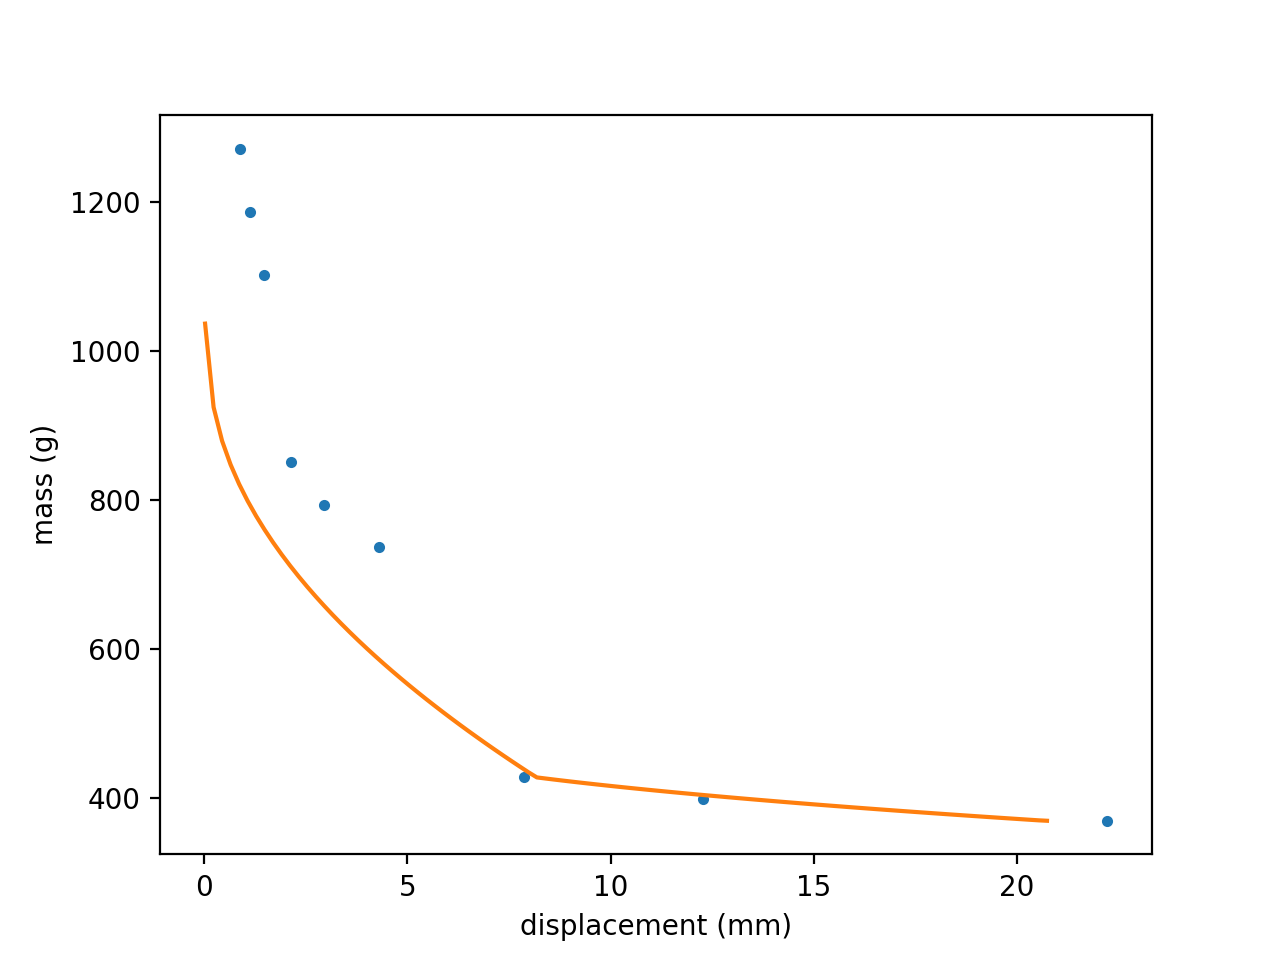

Text(0, 0.5, 'mass (g)')

In [52]:
fig = plt.figure()

# plot original DOE values as points
plt.plot(y[:,x_axis_index],y[:,y_axis_index],'.')
plt.plot(pareto_output_values[:,x_axis_index],pareto_output_values[:,y_axis_index])
plt.xlabel(x_axis_label)
plt.ylabel(y_axis_label)